# Globals

In [791]:
from Models import TransformerBase, BufferEmbedding, BufferEncoding
from Models.util.qol import manage_params
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time as clock
from torch import Tensor
from torch.nn import Module
from torch.optim import lr_scheduler
from copy import deepcopy

%matplotlib inline

In [792]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.float32

# Data creation

In [793]:
MULTIPLIER = 0.01

In [794]:
def create_data(records: int, limits: tuple[int, int], seq_len: int, min_len: int | None = None,
                step: int | None = None, offset: int | None = None, embedded: bool = False,
                device: torch.device = 'cpu', dtype: torch.dtype = torch.float32):
    limit_range = limits[1] - limits[0]
    assert limit_range > (seq_len * 2 // step) + offset
    if min_len is None:
        min_len = seq_len
    assert min_len > 0
    if step is None:
        step = 1
    if offset is None:
        offset = 0

    inputs = torch.stack([
        torch.cat([
            torch.arange(start, start + seq_len - padding, step, device=device, dtype=torch.float64),
            torch.full((padding,), -1, device=device, dtype=torch.float64),
        ])
        for start, padding in zip(
            np.random.randint(limits[0], limits[0] + (limit_range // 1) - max(0, offset + seq_len), records),
            np.random.randint(0, seq_len - min_len + 1, records)
        )
    ])
    # print(inputs)
    try:
        outputs = torch.stack([
            torch.arange(start, start + seq_len, step, device=device, dtype=torch.float64)
            for start in [
                inp[inp != -1].min().cpu().item() + 1 + offset
                for inp in inputs
            ]
            # for start in (torch.max(inputs, -1,)[0] + 1)
        ])
    except Exception as e:
        print(inputs[:3, [0, 1, -2, -1]])
        raise e
    # print(outputs)

    cdtype = torch.int64 if dtype == torch.float64 else torch.int64
    return tuple([
        (t * (MULTIPLIER if not embedded else 1)).to(dtype if not embedded else cdtype) for t in [inputs, outputs]
    ])

In [795]:
RECORDS = 2000
LIMITS = (0, 1000)
MAX_SEQ_LEN = 256
SEQ_LEN = 100
MIN_LEN = SEQ_LEN - 20
STEP = 1
OFFSET = 0
EMBEDDED = True

In [796]:
train_inp, train_out = create_data(RECORDS, LIMITS, SEQ_LEN, MIN_LEN, STEP, OFFSET, EMBEDDED, DEVICE, DTYPE)
eval_inp, eval_out = create_data(RECORDS // 1, LIMITS, SEQ_LEN, MIN_LEN, STEP, OFFSET, EMBEDDED, DEVICE, DTYPE)
train_inp.shape, train_out.shape, eval_inp.shape, eval_out.shape

(torch.Size([2000, 100]),
 torch.Size([2000, 100]),
 torch.Size([2000, 100]),
 torch.Size([2000, 100]))

In [797]:
train_inp.device, train_inp.dtype, eval_inp.device, eval_out.dtype

(device(type='cuda', index=0),
 torch.int64,
 device(type='cuda', index=0),
 torch.int64)

In [798]:
def print_tensor(tensor: Tensor, indices: list[int] | None = None):
    if not EMBEDDED:
        return torch.round(tensor[:, indices].to(torch.float64) / MULTIPLIER, decimals=0)
    else:
        return tensor

In [799]:
def sample_batch(*tensors: Tensor, n: int) -> tuple[Tensor, ...]:
    """
    Randomly sample n unique indices from the first dimension of a tensor.

    Args:
        tensor (torch.Tensor): Input tensor of shape (batch_size, ...).
        n (int): Number of samples to draw.

    Returns:
        torch.Tensor: Tensor subset with n unique rows.
    """
    assert len(tensors) > 0
    assert tensors[0].size(0) > 0
    batch_size = tensors[0].size(0)
    indices = torch.randperm(batch_size)[:n]  # unique, random order
    return tuple([t[indices] for t in tensors])

In [800]:
test_inp, test_out = sample_batch(eval_inp, eval_out, n=3)
test_indices = list(range(10)) + list(range(-10, 0))
test_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

In [801]:
print_tensor(test_inp, test_indices)

tensor([[651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
         665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678,
         679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692,
         693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706,
         707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720,
         721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734,
         735, 736,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1],
        [  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
          22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
          36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
          50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
          64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82

In [802]:
print_tensor(test_out, test_indices)

tensor([[652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665,
         666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679,
         680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693,
         694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707,
         708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721,
         722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735,
         736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749,
         750, 751],
        [  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
          23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
          37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
          51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
          79,  80,  81,  82,  83

In [803]:
class Dictionary(Module):
    def __init__(self, limits: tuple[int, int], max_seq_len: int, padding_value: int, multiplier = 0.01, embedded = False):
        super(Dictionary, self).__init__()
        self.point = abs(round(math.log10(multiplier)))
        self.mapping = {
            round(value * multiplier, self.point) if not embedded else int(value): index
            for index, value in enumerate(range(limits[0], limits[1] + max_seq_len))
        }
        self.mapping[
            round(padding_value * multiplier, self.point) if not embedded else int(padding_value)
        ] = max(list(self.mapping.values()))+1
        self.reverse = {value: key for key, value in self.mapping.items()}
        self.vocab_size = max(list(self.mapping.values()))+1

    def forward(self, tensor: Tensor):
        tensor = tensor.clone()
        for key in tensor.unique(False).tolist():
            key = round(key, self.point)
            tensor[tensor == key] = self.mapping[key]
        return tensor

In [804]:
dictionary = Dictionary(LIMITS, MAX_SEQ_LEN, -1, MULTIPLIER, EMBEDDED)
VOCAB_SIZE = dictionary.vocab_size
VOCAB_SIZE

1257

In [805]:
print_tensor(test_inp)

tensor([[651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
         665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678,
         679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692,
         693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706,
         707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720,
         721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734,
         735, 736,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
          -1,  -1],
        [  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
          22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
          36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
          50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
          64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
          78,  79,  80,  81,  82

In [806]:
print_tensor(dictionary(test_inp))

tensor([[ 651,  652,  653,  654,  655,  656,  657,  658,  659,  660,  661,  662,
          663,  664,  665,  666,  667,  668,  669,  670,  671,  672,  673,  674,
          675,  676,  677,  678,  679,  680,  681,  682,  683,  684,  685,  686,
          687,  688,  689,  690,  691,  692,  693,  694,  695,  696,  697,  698,
          699,  700,  701,  702,  703,  704,  705,  706,  707,  708,  709,  710,
          711,  712,  713,  714,  715,  716,  717,  718,  719,  720,  721,  722,
          723,  724,  725,  726,  727,  728,  729,  730,  731,  732,  733,  734,
          735,  736, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256,
         1256, 1256, 1256, 1256],
        [   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,
           20,   21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
           32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
           44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54, 

# Design model

In [807]:
class Transformer(Module):
    def __init__(self, features: int, max_seq_len: int, embed_size: int, layers: int, heads: int, bias: bool = False,
                 device: torch.device = 'cpu', dtype: torch.dtype = torch.float32, **options):
        super(Transformer, self).__init__()

        # Attributes
        self.max_seq_len                = max_seq_len
        self.embed_size                 = embed_size
        self.heads                      = heads
        self.device                     = device
        self.dtype                      = dtype
        self.discrete: bool             = manage_params(options, 'discrete', False)
        self.type                       = manage_params(options, 'type', 'continuous' if not self.discrete else 'discrete')
        self.differential: int | None   = manage_params(options, 'differential', False)
        self.epsilon: float | None      = manage_params(options, 'epsilon', 1e-9)
        self.probabilistic: bool        = manage_params(options, 'probabilistic', False)

        # Build
        self.embedder = BufferEmbedding(
            1 if self.type == 'continuous' else features, embed_size, True, self.type,
            device, dtype, padding_idx=manage_params(options, 'padding_idx', None),
        )
        # self.encoder = BufferEncoding(max_seq_len, embed_size, True, 'discrete', device, dtype)
        self.encoder = nn.Identity()
        self.transformer = TransformerBase(max_seq_len, embed_size, layers, heads, None, self.differential, True, bias,
                                           device, dtype, constant=100)
        self.projection = nn.Sequential(
            nn.RMSNorm(embed_size, self.epsilon, True, device, dtype),
            nn.Linear(
                embed_size,
                (1 if self.type == 'continuous' else features) * 2,
                True, device, dtype
            )
        )
        self.eval()

    def extra_repr(self) -> str:
        return f"probabilistic={self.probabilistic}, discrete={self.discrete}"

    def forward(self, tensor: Tensor, verbose: int = None, pos_idx: int = None, single: bool = False, get: bool = False):
        squeeze = tensor.ndim == 1
        if squeeze:
            tensor = tensor.unsqueeze(0)
        if self.type == 'continuous':
            tensor = tensor.unsqueeze(-1)
        embedding = self.embedder(tensor, verbose=verbose)
        encoding = self.encoder(embedding) #, verbose=verbose)
        transformation = self.transformer(encoding, verbose=verbose, pos_idx=pos_idx, single=single, get=get)
        tensor = self.projection(transformation)
        mean, log_std = torch.chunk(tensor, 2, -1)
        tensor = mean
        if self.probabilistic:
            std = torch.exp(log_std)
            if self.training:
                tensor = tensor + (std * torch.randn_like(std))
            else:
                dist = torch.distributions.Normal(mean, std)
                tensor = dist.sample()
        if single:
            tensor = tensor.squeeze(1)
        if self.type == 'continuous':
            tensor = tensor.squeeze(-1)
        if squeeze:
            tensor = tensor.squeeze(0)
        return tensor

    def evaluate(self, tensor: Tensor, verbose: int = None, pos_idx: int = None, single: bool = False, get: bool = False):
        tensor = self(tensor, verbose, pos_idx, single, get)
        if self.type == 'continuous':
            return tensor
        elif self.type == 'discrete':
            return torch.argmax(tensor, dim=-1)
        else:
            raise ValueError("Unsupported type.")

In [808]:
test_model = Transformer(VOCAB_SIZE, MAX_SEQ_LEN, 4, 2, 1, False, DEVICE, DTYPE, discrete=EMBEDDED)
test_model

Transformer(
  probabilistic=False, discrete=True
  (embedder): BufferEmbedding(
    (embedding): Embedding(1257, 4)
  )
  (encoder): Identity()
  (transformer): TransformerBase(
    (layers): ModuleList(
      (0-1): 2 x TransformerBlock(
        (self_attention): Attention(
          *** residual=True, normalize=True, auto_single=False. causal_mask=True***
          (pre_norm): RMSNorm((4,), eps=1e-09, elementwise_affine=True)
          (query_proj): Linear(in_features=4, out_features=4, bias=False)
          (key_proj): Linear(in_features=4, out_features=4, bias=False)
          (value_proj): Linear(in_features=4, out_features=4, bias=False)
          (out_proj): Linear(in_features=4, out_features=4, bias=False)
          (rotary_embedding): RoPE()
          (softmax): Softmax(dim=-1)
          (head_norm): RMSNorm((4,), eps=1e-09, elementwise_affine=True)
        )
        (feedforward): SwiGLU(
          *** residual=False, normalize=False, ***
          (inp_proj): Linear(in_feat

In [809]:
def get(tensor: Tensor):
    if not EMBEDDED:
        return tensor
    else:
        return dictionary(tensor)

In [810]:
test_inp.max(), test_inp.min()

(tensor(736, device='cuda:0'), tensor(-1, device='cuda:0'))

In [811]:
with torch.no_grad():
    print(test_model.evaluate(get(test_inp), verbose=2, pos_idx=-1).shape)

Embedded Tensor => torch.Size([3, 100, 4])

Executing Self Attention
Input => torch.Size([3, 100, 4])
Post Linearization =>
Query => torch.Size([3, 100, 4])
Key => torch.Size([3, 100, 4])
Value => torch.Size([3, 100, 4])
Q after Reshaping => torch.Size([3, 100, 1, 4])
K after Reshaping => torch.Size([3, 100, 1, 4])
Q after Rotary Embedding => torch.Size([3, 100, 1, 4])
K after Rotary Embedding => torch.Size([3, 100, 1, 4])
Duplicated K => torch.Size([3, 100, 1, 4])
Duplicated V => torch.Size([3, 100, 1, 4])
Energy => torch.Size([3, 1, 100, 100])
Mask => torch.Size([3, 1, 100, 100])
Masked Energy => torch.Size([3, 1, 100, 100])
Attention Score => torch.Size([3, 1, 100, 100])
Attented Values => torch.Size([3, 100, 4])
Output Projection => torch.Size([3, 100, 4])
TransformerBlock Output => torch.Size([3, 100, 4])

Executing Self Attention
Input => torch.Size([3, 100, 4])
Post Linearization =>
Query => torch.Size([3, 100, 4])
Key => torch.Size([3, 100, 4])
Value => torch.Size([3, 100, 4])


# Parameters

In [812]:
EMBED_SIZE = 64
LAYERS = 3
HEADS = 1
BIAS = False
DIFFERENTIAL = False
PROBABILISTIC = False

# Create model

In [813]:
model = Transformer(VOCAB_SIZE, MAX_SEQ_LEN, EMBED_SIZE, LAYERS, HEADS, BIAS, DEVICE, DTYPE,
                    differential=DIFFERENTIAL, discrete=EMBEDDED, probabilistic=PROBABILISTIC,)
model

Transformer(
  probabilistic=False, discrete=True
  (embedder): BufferEmbedding(
    (embedding): Embedding(1257, 64)
  )
  (encoder): Identity()
  (transformer): TransformerBase(
    (layers): ModuleList(
      (0-2): 3 x TransformerBlock(
        (self_attention): Attention(
          *** residual=True, normalize=True, auto_single=False. causal_mask=True***
          (pre_norm): RMSNorm((64,), eps=1e-09, elementwise_affine=True)
          (query_proj): Linear(in_features=64, out_features=64, bias=False)
          (key_proj): Linear(in_features=64, out_features=64, bias=False)
          (value_proj): Linear(in_features=64, out_features=64, bias=False)
          (out_proj): Linear(in_features=64, out_features=64, bias=False)
          (rotary_embedding): RoPE()
          (softmax): Softmax(dim=-1)
          (head_norm): RMSNorm((64,), eps=1e-09, elementwise_affine=True)
        )
        (feedforward): SwiGLU(
          *** residual=False, normalize=False, ***
          (inp_proj): Lin

In [814]:
with torch.no_grad():
    print(model(get(test_inp), verbose=2,).shape)

Embedded Tensor => torch.Size([3, 100, 64])

Executing Self Attention
Input => torch.Size([3, 100, 64])
Post Linearization =>
Query => torch.Size([3, 100, 64])
Key => torch.Size([3, 100, 64])
Value => torch.Size([3, 100, 64])
Q after Reshaping => torch.Size([3, 100, 1, 64])
K after Reshaping => torch.Size([3, 100, 1, 64])
Q after Rotary Embedding => torch.Size([3, 100, 1, 64])
K after Rotary Embedding => torch.Size([3, 100, 1, 64])
Duplicated K => torch.Size([3, 100, 1, 64])
Duplicated V => torch.Size([3, 100, 1, 64])
Energy => torch.Size([3, 1, 100, 100])
Mask => torch.Size([3, 1, 100, 100])
Masked Energy => torch.Size([3, 1, 100, 100])
Attention Score => torch.Size([3, 1, 100, 100])
Attented Values => torch.Size([3, 100, 64])
Output Projection => torch.Size([3, 100, 64])
TransformerBlock Output => torch.Size([3, 100, 64])

Executing Self Attention
Input => torch.Size([3, 100, 64])
Post Linearization =>
Query => torch.Size([3, 100, 64])
Key => torch.Size([3, 100, 64])
Value => torch.S

# Train model

In [815]:
def get_batches(count: int, batch_size: int, randomize=False):
    batch_total = math.ceil(count / batch_size)
    batch_indices = [
        list(range(i * batch_size, i * batch_size + min(batch_size, count - i * batch_size)))
        for i in range(batch_total)
    ]
    if randomize:
        random.shuffle(batch_indices)
        for batch in batch_indices:
            random.shuffle(batch)
    return batch_indices

In [816]:
def get_accuracy(model: Transformer, inputs: Tensor, outputs: Tensor, error: float = 0.03, batches: int = None, epsilon=1e-4):
    inputs, outputs = get(inputs), get(outputs)
    torch.cuda.empty_cache()
    if batches is None:
        batches = len(inputs)
    if isinstance(batches, int):
        batches = get_batches(len(outputs), batches, False)
    elif isinstance(batches, list):
        pass
    else:
        raise NotImplemented(f"Batches must be an Integer or List of batch indices")

    with torch.no_grad():
        summation = count = 0
        for batch in batches:
            prediction = model.evaluate(inputs[batch])
            target = outputs[batch] + (epsilon if not EMBEDDED else 0)
            total = torch.sum(
                (((target * (1 + error)) > prediction) & (prediction > (target * (1 - error))))
                if not EMBEDDED else
                prediction == target
            ).cpu().item()
            # print(prediction, target)
            summation += total
            count += target.numel()
        accuracy = summation / count
    return round(accuracy, 4)

In [817]:
EVAL_BATCH_SIZE = 128

In [818]:
get_accuracy(model, train_inp, train_out, 0.5, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.5, EVAL_BATCH_SIZE)

(0.0008, 0.0009)

In [819]:
get_accuracy(model, train_inp, train_out, 0.1, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.1, EVAL_BATCH_SIZE)

(0.0008, 0.0009)

In [820]:
get_accuracy(model, train_inp, train_out, 0.03, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.03, EVAL_BATCH_SIZE)

(0.0008, 0.0009)

In [821]:
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0e-4
EPOCHS = 50

In [822]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

In [823]:
torch.cuda.empty_cache()

In [824]:
def eta(time_start, units_done, units_total, text=''):
    time_done = clock.perf_counter() - time_start
    progress = round(units_done / units_total * 100)
    rem = round(time_done / units_done * (units_total - units_done))
    # print(f"\r{text}: progress={progress}% eta={rem}sec", end='')
    print(f"\reta={rem}s", end='')

In [825]:
def plot_data(data: list[list[float]], labels: list[str], size=(14.4, 3.6)):
    axes = plt.subplots(1, len(data), figsize=size)[1]
    if len(data) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for axis, data, label in zip(axes, data, labels):
        if 'loss' in label.lower():
            data = np.log10(np.array(data))
        axis.plot(data)
        axis.set_title(label)
    plt.show()

In [826]:
def train(model: Transformer, optimizer: optim.Optimizer, scheduler: lr_scheduler.LRScheduler, epochs: int, batch_size: int):
    torch.cuda.empty_cache()
    train_batches = get_batches(len(train_inp), batch_size, randomize=True)
    eval_batches = get_batches(len(eval_inp), batch_size, randomize=True)
    train_inp_ = get(train_inp)
    eval_inp_ = get(eval_inp)

    def eval(prediction: Tensor, target: Tensor):
        if not EMBEDDED:
            return F.mse_loss(prediction, target)
        else:
            return F.cross_entropy(prediction.view(-1, prediction.shape[-1]), target.view(-1))

    model.eval()
    with torch.no_grad():
        eval_loss = 0.0
        for batch in eval_batches:
            batch_loss = eval(model(eval_inp_[batch]), eval_out[batch])
            eval_loss += batch_loss.cpu().item()
        eval_loss /= len(train_batches)

    t_losses, e_losses = [], []
    t_accuracy, e_accuracy = [], []

    ts, ud, ut = clock.perf_counter(), 0, epochs
    best_loss, best_epoch = eval_loss, -1
    save_state = tuple([deepcopy(obj.state_dict()) for obj in [model, optimizer, scheduler]])
    try:
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for batch in train_batches:
                batch_loss = eval(model(train_inp_[batch]), train_out[batch])
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

                train_loss += batch_loss.cpu().item()
            train_loss /= len(train_batches)
            train_acc = get_accuracy(model, train_inp, train_out, 0.03, train_batches)

            scheduler.step()

            model.eval()
            with torch.no_grad():
                eval_loss = 0.0
                for batch in eval_batches:
                    batch_loss = eval(model(eval_inp_[batch]), eval_out[batch])

                    eval_loss += batch_loss.cpu().item()
                eval_loss /= len(train_batches)
                eval_acc = get_accuracy(model, eval_inp, eval_out, 0.03, eval_batches)

            if eval_loss < best_loss:
                best_loss = eval_loss
                best_epoch = epoch
                save_state = tuple([deepcopy(obj.state_dict()) for obj in [model, optimizer, scheduler]])

            t_losses.append(train_loss)
            e_losses.append(eval_loss)
            t_accuracy.append(train_acc)
            e_accuracy.append(eval_acc)

            ud += 1
            eta(ts, ud, ut, f"Training model: train_loss={train_loss:.4e}, eval_loss={eval_loss:.4e}, "
                            f"train_acc={train_acc*100:.2f}%, eval_acc={eval_acc*100:.2f}%, be={best_epoch}")
        optimizer.zero_grad()
    except KeyboardInterrupt:
        pass
    for ss, obj in zip(save_state, [model, optimizer, scheduler]):
        obj.load_state_dict(ss)
    print(f"\nCompleted training in {clock.perf_counter() - ts:.2f} s. Loaded epoch {best_epoch}")

    torch.cuda.empty_cache()
    model.eval()
    plot_data([t_losses, e_losses, t_accuracy, e_accuracy],
              ['Train Loss', 'Eval Loss', 'Train Accuracy', 'Eval Accuracy'])
    return t_losses, e_losses, t_accuracy, e_accuracy

In [827]:
TRAIN_BATCH_SIZE = 64

eta=0sss
Completed training in 244.43 s. Loaded epoch 49


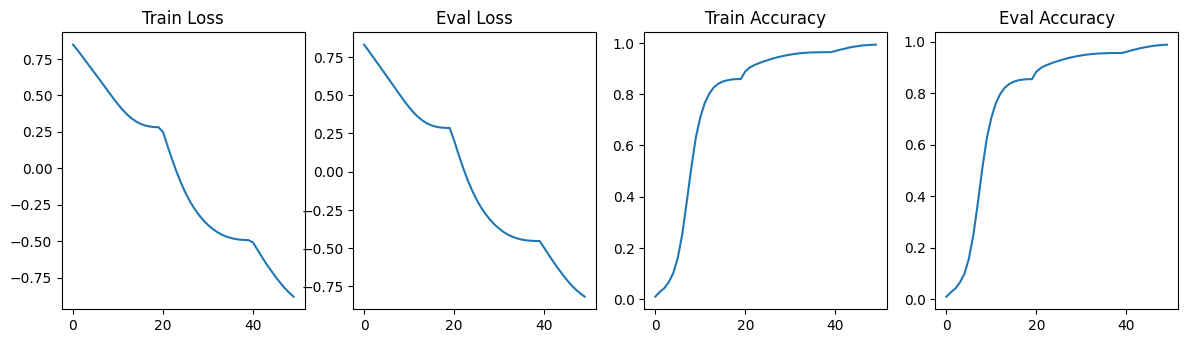

In [828]:
train(model, optimizer, scheduler, EPOCHS, TRAIN_BATCH_SIZE);

eta=0sss
Completed training in 242.77 s. Loaded epoch 49


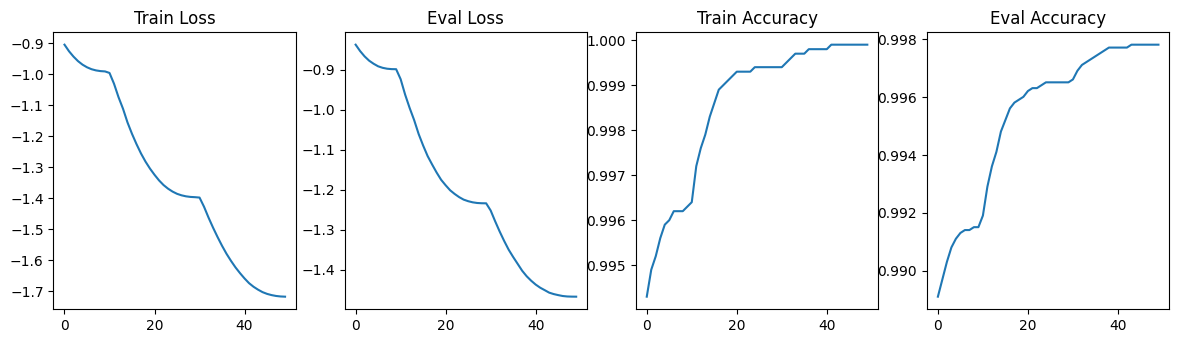

In [829]:
train(model, optimizer, scheduler, EPOCHS, TRAIN_BATCH_SIZE);

# Evaluate model

Accuracy

In [830]:
get_accuracy(model, train_inp, train_out, 0.5, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.5, EVAL_BATCH_SIZE)

(0.9999, 0.9978)

In [831]:
get_accuracy(model, train_inp, train_out, 0.1, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.1, EVAL_BATCH_SIZE)

(0.9999, 0.9978)

In [832]:
get_accuracy(model, train_inp, train_out, 0.03, EVAL_BATCH_SIZE), \
get_accuracy(model, eval_inp, eval_out, 0.03, EVAL_BATCH_SIZE)

(0.9999, 0.9978)

Training data

In [833]:
test_inp, test_out = sample_batch(train_inp, train_out, n=3)

In [834]:
print_tensor(test_inp)[:, -10:]

tensor([[969, 970, 971, 972, 973,  -1,  -1,  -1,  -1,  -1],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
        [ -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]], device='cuda:0')

In [835]:
print_tensor(test_out)[:, -10:]

tensor([[970, 971, 972, 973, 974, 975, 976, 977, 978, 979],
        [537, 538, 539, 540, 541, 542, 543, 544, 545, 546],
        [717, 718, 719, 720, 721, 722, 723, 724, 725, 726]], device='cuda:0')

In [836]:
with torch.no_grad():
    test_pred = model.evaluate(get(test_inp))
print_tensor(test_pred)[:, -10:]

tensor([[970, 971, 972, 973, 974, 975, 976, 977, 978, 979],
        [537, 538, 539, 540, 541, 542, 543, 544, 545, 546],
        [717, 718, 719, 720, 721, 722, 723, 724, 725, 726]], device='cuda:0')

Evaluation data

In [837]:
test_inp, test_out = sample_batch(train_inp, train_out, n=4)

In [838]:
print_tensor(test_inp)[:, -10:];

In [839]:
print_tensor(test_out)[:, -10:]

tensor([[419, 420, 421, 422, 423, 424, 425, 426, 427, 428],
        [891, 892, 893, 894, 895, 896, 897, 898, 899, 900],
        [114, 115, 116, 117, 118, 119, 120, 121, 122, 123],
        [145, 146, 147, 148, 149, 150, 151, 152, 153, 154]], device='cuda:0')

In [840]:
with torch.no_grad():
    test_pred = model.evaluate(get(test_inp))
print_tensor(test_pred)[:, -10:]

tensor([[419, 420, 421, 422, 423, 424, 425, 426, 427, 428],
        [891, 892, 893, 894, 895, 896, 897, 898, 899, 900],
        [114, 115, 116, 117, 118, 119, 120, 121, 122, 123],
        [145, 146, 147, 148, 149, 150, 151, 152, 153, 154]], device='cuda:0')

In [841]:
with torch.no_grad():
    test_position = model.evaluate(get(test_inp), single=True)
print_tensor(test_position)

tensor([428, 900, 123, 154], device='cuda:0')

In [842]:
with torch.no_grad():
    test_position = model.evaluate(get(test_inp), single=True, pos_idx=-1)
print_tensor(test_position)

tensor([428, 900, 123, 154], device='cuda:0')

# View attention

In [843]:
def plot_attention(inputs: Tensor, layer_index: int | None = None, size=(1440, 1080), inverse=False,
                   cmap='bone_r', crop=1, exg=1, single=False, force_line=False):
    assert inputs.ndim == 1
    plt.close()

    # Calculate attention
    with torch.no_grad():
        model.evaluate(get(inputs), get=True, single=single).cpu()
        tx_base = model.transformer

    # Get layers self attention
    self_attention = [l[0].to('cpu', torch.float64) for l in tx_base.get_attention()]
    if layer_index is not None:
        self_attention = self_attention[[layer_index]]
    # if layer_index is not None:
    #     self_attention = self_attention[layer_index].to('cpu', torch.float64)
    # else:
    #     self_attention = torch.mean(torch.stack(self_attention), dim=0).to('cpu', torch.float64)
    b, heads, q, k = self_attention[0].shape
    rows = heads
    columns = len(self_attention) if layer_index is None else 1
    # print(rows, columns)
    fig, axes = plt.subplots(rows, columns, figsize=(size[0] * 0.01, size[1] * 0.01))
    # fig.patch.set_facecolor(bg)
    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    else:
        if rows == 1:
            axes = np.expand_dims(axes, 0)
        if columns == 1:
            axes = np.expand_dims(axes, 1)
    if inverse:
        axes = axes.transpose()
    # print(axes.shape)
    x = 0
    for li, attention in enumerate(self_attention):
        for hi, att_head in enumerate(attention[0]):
            title = f"L{li if layer_index is None else layer_index} H{hi}"
            if force_line:
                att_head = att_head[[-1]]
            q, k = att_head.shape[-2:]
            # print(q, k)
            if q != 1:
                # att_head = att_head.expand(k, k)
                # q = k
                if exg is not None:
                    att_head = torch.clamp(att_head * exg, 0, 1)
                if crop is not None:
                    k_red = k // crop
                    k_max = max(1, k // 2 - k_red)
                    k_idx = np.random.randint(k_max)
                    k_ind = torch.arange(k_idx, k_idx + k_red).to(att_head.device)
                    q_red = min(q, q // crop)
                    q_max = max(1, q // 2 - q_red)
                    q_idx = np.random.randint(q_max)
                    q_ind = torch.arange(q_idx, q_idx + q_red).to(att_head.device)
                    # print(q_ind, k_ind, att_head.shape)
                    # print(att_head.shape, q_ind.shape, k_ind.shape, q, k)
                    att_head = torch.index_select(torch.index_select(att_head, 0, q_ind), 1, k_ind)
                    # print(att_head.shape)
                axes[x].imshow(att_head.float().cpu(), cmap=cmap)
            else:
                axes[hi, li].plot(att_head.squeeze(0))
            axes[hi, li].set_title(title)
            x += 1
    plt.show()

torch.Size([100]) 4


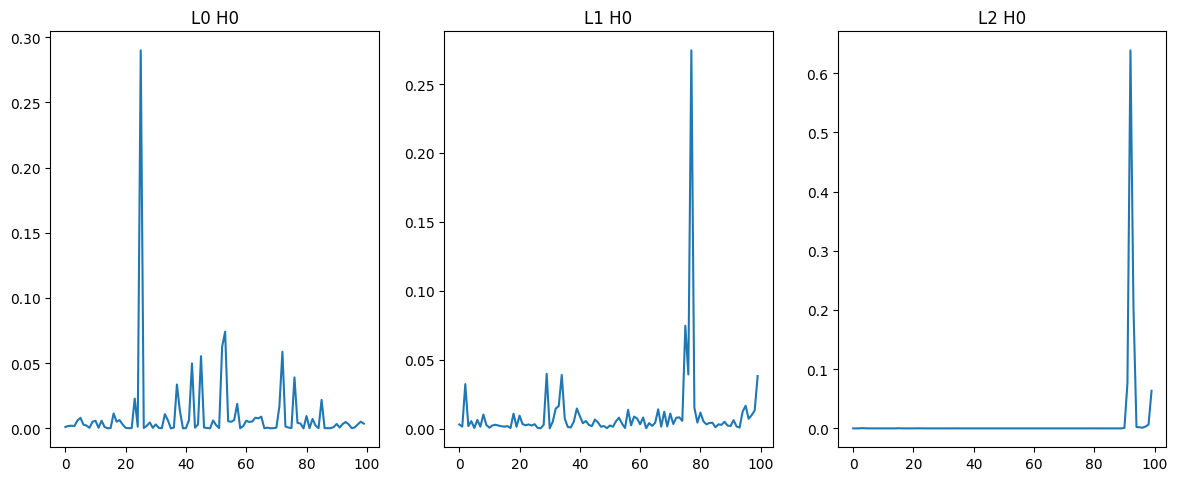

In [933]:
sample_input = sample_batch(eval_inp, n=1)[0][0]
missing_count = torch.count_nonzero(torch.round(sample_input.to(torch.float) / MULTIPLIER) if not EMBEDDED else sample_input == -1).cpu().item()
print(sample_input.shape, missing_count)
plot_attention(sample_input, layer_index=None, size=(1440, 540), crop=1, exg=3, single=True, force_line=True)

torch.Size([100]) 0


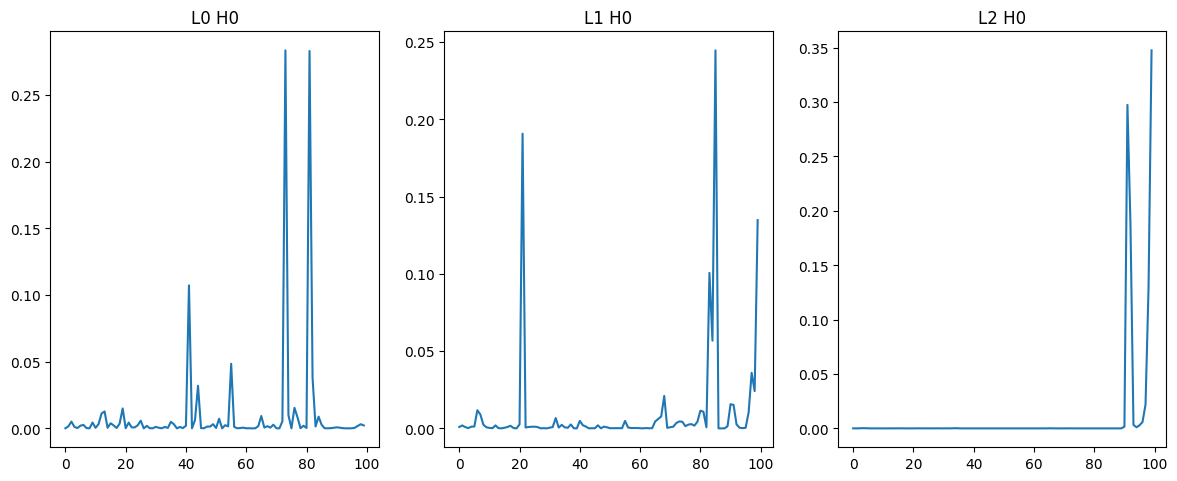

In [910]:
sample_input = sample_batch(eval_inp, n=1)[0][0]
missing_count = torch.count_nonzero(torch.round(sample_input.to(torch.float) / MULTIPLIER) == -1).cpu().item()
print(sample_input.shape, missing_count)
plot_attention(sample_input, layer_index=None, size=(1440, 540), crop=1, exg=3, single=False, force_line=True)

# View generation

In [846]:
def evaluate(model: Transformer, start_value: int, length: int, seq_len: int | None = None):
    if seq_len is None:
        seq_len = SEQ_LEN
    print(start_value, length)
    last_value = start_value + (seq_len * STEP)
    tensor = torch.arange(
        start_value, last_value, STEP,
        device=model.device, dtype=model.dtype if not EMBEDDED else torch.int64
    )
    result_start = last_value + OFFSET
    expected = torch.arange(result_start, result_start + length, device='cpu', dtype=torch.float64)
    generated = []

    # print(tensor)
    # print(expected)
    for step in range(length):
        with torch.no_grad():
            if not EMBEDDED:
                prediction = torch.round(model(tensor * MULTIPLIER, single=True) / MULTIPLIER, decimals=0)
            else:
                prediction = model.evaluate(get(tensor), single=True)
        generated.append(prediction)
        # print(expected.shape, prediction.shape, prediction, expected[step])
        tensor[:-1] = tensor[1:].clone()
        tensor[-1] = prediction

    generated = torch.stack(generated, 0).to('cpu', torch.float64)

    plt.close()
    plt.plot(expected, label='expected')
    plt.plot(generated, label='generated')
    plt.legend()
    plt.show()

417 10


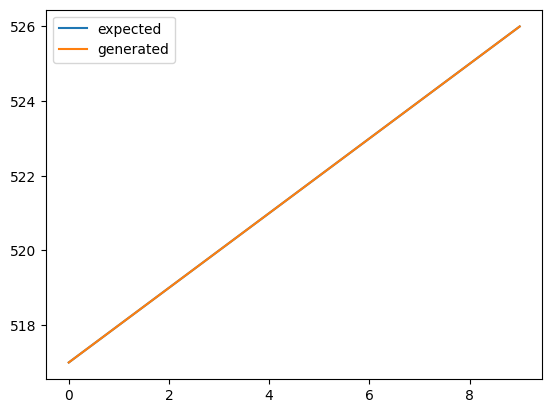

In [1017]:
evaluate(model, start_value=random.randint(100, 1000), length=10, seq_len=None)